# Tutorial: A Beginner's Guide to Probabilistic Generative Models and the CRep Algorithm

Welcome to this tutorial on using the _Probabilistic Generative Models for Network Analysis_ (`pgm`) package. In this tutorial, we'll walk through the process of running the `CRep` algorithm on a sample dataset.

The `CRep` algorithm (which name comes from a mix of "Community and Reciprocity") is a probabilistic generative model used for network analysis. It is designed to detect communities within a network and quantify the level of reciprocity. Reciprocity, in this context, refers to the tendency of node pairs to form mutual connections.

## Package Structure
Before delving into the usage of the _CRep_ algorithm, let's explore the structure of the `pgm` package, which is organized into four main modules:

### 1. Input
The `input` module handles data input for subsequent use by the algorithms in the `model` module. It comprises the following submodules:  

- `loader`: Functions to load data from input files.  
- `preprocessing`: Functions for data preprocessing, such as converting NetworkX graphs to sparse adjacency matrices.  
- `tools`: Utility functions for working with matrices, tensors, and sparsity.  
- `stats`: Functions for computing statistics on the data.  
- `generate_networks`: Functions for generating synthetic networks.  

In most cases where users have their own data, they typically use only the `loader` and `preprocessing` modules. The other modules serve as internal components supporting these primary functionalities. The `generate_networks` module is utilized when no data is available, and the user wants to generate synthetic networks.

### 2. Model
The `model` module encompasses the implementation of various algorithms, including the following submodules:  

- `CRep`: Implementation of the `CRep` algorithm.  
- `JointCRep`: Implementation of the `JointCRep` algorithm. 
- `cv_CRep`: Cross-validation for the CRep algorithm.
- `cv`: Implementation of the general cross-validation algorithm.  


### 3. Output
The `output` module contains functions responsible for handling the outputs of the models. It consists of the following submodules:

- `evaluate`: Essential functions for model assessment, such as AUC for link prediction, conditional and marginal expectations, and the pseudo log-likelihood of the data.
- `plot`: Functions for visualizing the results and performance metrics of the models.

### 4. Data
The `data` module contains the data files used by the package. It consists of the following submodules:

- `input`: Input data files.
- `model`: Configuration files for the models.

Having explored the package structure, let's see how to use it to run the `CRep` algorithm.

## Configuration
Let's start by configuring the algorithm and the parameters needed. The pipeline works based on two types of parameters:

**Numerical Parameters:** these are operational parameters that control the execution of the algorithm. They are not directly related to the model's theoretical framework but are crucial for its practical implementation. Examples include:

- **Convergence tolerance:** This is a threshold used to determine when the algorithm has converged, i.e., when the changes in the model's parameters between iterations are small enough to consider the model as having reached its final state.

- **Maximum number of iterations:** This is the maximum number of times the algorithm will update the model's parameters. If the model hasn't converged by this point, the algorithm will stop anyway.

- **Number of realizations:** In the context of the `CRep` algorithm, this refers to the number of times the entire process (initialization and iterative updates) is repeated. This is done to account for the randomness in the initialization step and to ensure a more robust final model. 

These are set by default in the model's class definition, but they can be changed by the user.

**Model parameters:**  These are parameters that are part of the model's theoretical framework. They have a direct impact on the model's behavior and the results it produces. Examples include:

- **Number of communities (K)**: This is a fundamental parameter of the `CRep` algorithm. It determines the number of communities the algorithm will try to find in the network. Each node in the network will be assigned to one of these communities, at least.

- **Reciprocity coefficient (eta)**: This is another fundamental parameter of the `CRep` algorithm. It quantifies the level of reciprocity in the network, i.e., the tendency of node pairs to form mutual connections.

These are set by the user in the configuration file corresponding to the used model. In the case of the `CRep` algorithm, this file is `setting_CRep.yaml`.  

Notice that the data is not a parameter, but an input to the algorithm, hence, it is not included in the default configuration of the class nor in the configuration file. This will be shown later in the tutorial.

In [1]:
from pathlib import Path

import numpy as np
import yaml

Let's start by loading the configuration file for the _CRep_ algorithm. This file is located in the `pgm/data/model` folder. 

In [2]:
# Set the algorithm to 'CRep'
algorithm = 'CRep'

# Define the path to the configuration file for the 'CRep' algorithm
config_path = 'setting_' + algorithm + '.yaml'

We load the configuration file using the data files in the `pgm` package instead of a relative path to it:

In [4]:
# Import the 'open_binary' function from the 'importlib.resources' module
# This function is used to open a binary file included in a package
from importlib.resources import open_binary

# Open the configuration file for the 'CRep' algorithm
# The 'open_binary' function takes two arguments:
# - The name of the package where the file is located ('pgm.data.model')
# - The name of the file to open ('config_path')
# The function returns a binary file object, which is opened in read mode
with open_binary('pgm.data.model', config_path) as fp:
    # Load the contents of the configuration file into a dictionary
    # The 'load' function from the 'yaml' module is used to 
    # convert the data from a YAML formatted string into a Python dictionary.
    # The 'Loader=yaml.Loader' argument specifies the loader class to use for 
    # loading the data.
    conf = yaml.load(fp, Loader=yaml.Loader)

In [5]:
# Print the configuration file
print(yaml.dump(conf))

K: 3
assortative: true
constrained: true
end_file: _test
eta0: null
files: config/data/input/theta_gt111.npz
fix_eta: false
initialization: 0
out_folder: outputs/
out_inference: true
rseed: 0
undirected: false


The previous file shows the parameters actually needed to _run_ the model. These parameters set the algorithms basic needs to work.  

 

Now, let's change the path to the output folder, so we can save the results into the same folder where this notebook is. 

In [6]:
# Set the output folder for the 'CRep' algorithm
# The output folder is set to the current directory, with 
# the folder name being the algorithm name followed by '_output/'
conf['out_folder'] = './' + algorithm + '_output/'

# Set the end file for the 'CRep' algorithm
# The end file is set to be '_' followed by the algorithm name
conf['end_file'] = '_' + algorithm

In [7]:
# Define the output folder
out_folder = Path(conf['out_folder'])

# Ensure the output folder exists
out_folder.mkdir(parents=True, exist_ok=True)

Finally, let's save this configuration file to the output folder, so we can keep track of the parameters used to run the model.

In [8]:
# Define the path for the output configuration file
# The output configuration file is located in the output folder for 
# the 'CRep' algorithm.
# The file name is 'setting_' followed by the algorithm name with 
# a '.yaml' extension.
output_config_path = conf['out_folder'] + '/setting_' + algorithm + '.yaml'

# Open the output configuration file in write mode
with open(output_config_path, 'w') as f:
    # Write the contents of the 'conf' dictionary to the file
    # The 'dump' function from the 'yaml' module is used to convert 
    # the data from a Python dictionary into a YAML formatted string.
    # The 'f' argument specifies the file object where the 
    # data should be written.
    yaml.dump(conf, f)

## Importing Data
Once the configuration file is set, we can import the data. 
Now, let's import the data using the `pgm` package:

In [9]:
from pgm.input.loader import import_data

# Define the names of the columns in the input file that 
# represent the source and target nodes of each edge
ego = 'source'
alter = 'target'

# Set the 'force_dense' flag to False
# This flag determines whether the adjacency matrices 
# should be stored as dense matrices.
# If set to False, the adjacency matrices will be stored 
# as sparse matrices, which is more memory-efficient 
# for large networks with few edges.
force_dense = False

# Get the absolute path of the root directory of the project
root_dir = Path.cwd().parent.parent.parent.resolve()

# Define the path to the input folder
in_folder = root_dir / 'pgm/data/input/'

# Define the name of the input file
adj = Path('syn111.dat')

# Combine the paths to the input folder and the input file 
# to get the complete path to the input file.
network = in_folder / adj

# Call the 'import_data' function to load the data from the input file
# The function takes several arguments:
# - The path to the input file ('network')
# - The names of the columns in the input file that represent the source 
# and target nodes of each edge ('ego' and 'alter')
# - The 'force_dense' flag
# - The number of the row in the input file that contains the header (0)
A, B, B_T, data_T_vals = import_data(network,
                                     ego=ego,
                                     alter=alter,
                                     force_dense=force_dense,
                                     header=0)

/home/dtheuerkauf/software-workshop/prob-gen-model-for-nets/pgm/data/input/syn111.dat shape: (5512, 3)
Creating the network ... Removing self loops

Number of nodes = 600
Number of layers = 1
Number of edges and average degree in each layer:
E[0] = 5512 - <k> = 18.373
Sparsity [0] = 0.015
Reciprocity (networkX) = 0.423
Reciprocity (intended as the proportion of bi-directional edges over the unordered pairs) = 0.268

Reciprocity (considering the weights of the edges) = 0.423


The previous call to `import_data` loads the data from the input folder, and returns the following:

- `A`: A list of NetworkX graphs, where each graph represents a snapshot of the network.  
- `B`: A list of (sparse) adjacency matrices, where each matrix represents a snapshot of the network.   
- `B_T`: A list of (sparse) adjacency matrices, where each matrix represents a snapshot of the network, but with the rows and columns transposed.  
- `data_T_vals`: Array with values of entries `A[j, i]` given non-zero entry `(i, j)`.  

Notice that `A` is this time consisting of only one graph, since we are using a single network. However, the _CRep_ algorithm can handle multiple networks, and in that case `A` would be a list of graphs.

In [9]:
len(A)

1

The basic statistics related to the data have been shown after importing them. But if we are interested in seeing them again, we can compute them using the `statistics` module:

In [10]:
from pgm.input.stats import print_graph_stat

# Call the 'print_graph_stat' function to print the basic 
# statistics of the graphs in the list 'A'.
# The function takes two arguments:
# - A list of NetworkX graphs ('A')
print_graph_stat(A)

Number of edges and average degree in each layer:
E[0] = 5512 - <k> = 18.373
Sparsity [0] = 0.015
Reciprocity (networkX) = 0.423
Reciprocity (intended as the proportion of bi-directional edges over the unordered pairs) = 0.268


We can see now that the network has 600 nodes, 5512 edges, average degree of 18.3733, and reciprocity of 0.423. 

Let's take a look at the graph. Since it has a very large number of edges, we will show its adjacency matrix instead:

In [11]:
type(B)

sktensor.sptensor.sptensor

In [12]:
# Convert the sparse adjacency matrix 'B' to a dense array 
# using the 'toarray' method.
# Then, reshape this array into a 2D array with the same 
# number of rows and columns as the original adjacency matrix.
# The 'reshape' method takes two arguments:
# - The number of rows in the reshaped array ('B.shape[1]')
# - The number of columns in the reshaped array ('B.shape[2]')
B_reshaped = B.toarray().reshape(B.shape[1], B.shape[2])

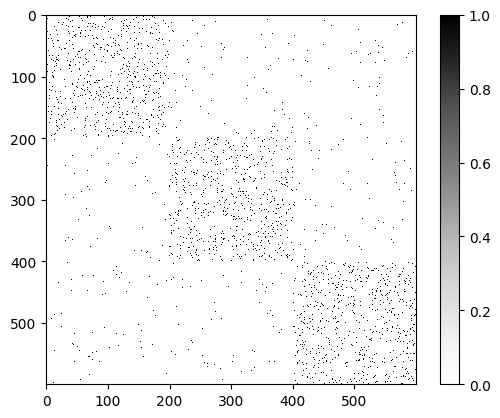

In [13]:
# Import the 'pyplot' module from 'matplotlib' for creating 
# static, animated, and interactive visualizations in Python.
import matplotlib.pyplot as plt

# Display the reshaped adjacency matrix 'B_reshaped' as an image.
# The 'imshow' function from the 'pyplot' module is used to 
# display data as an image.
# The 'cmap' argument specifies the colormap to use for the image.
# The 'interpolation' argument specifies the interpolation method
# to use when resizing the image.
plt.imshow(B_reshaped, cmap='Greys', interpolation='none')

# Add a color bar to the plot for reference.
# The colors in the color bar correspond to the values in the image:
# black for 1, meaning no connection, and white for 0, meaning a connection.
plt.colorbar()

As we can in the matrix, the network is not fully connected, i.e., there are nodes that are not connected to any other node. This is a common characteristic of real-world networks. More importantly, we can see that the network has three main clusters of nodes, which are the communities that the _CRep_ algorithm will try to detect.

## Running the Model
Finally, we are ready to run the _CRep_ model! The way this works is in a two-step process: first, we called the `CRep` class, which initializes the model. Then, we call the `fit` method, which runs the algorithm. 

In [14]:
# Import the 'CRep' class from the 'pgm.model.crep' module
# This class is used to create an instance of the 'CRep' algorithm
from pgm.model.crep import CRep

# Import the 'time' module
# This module provides various time-related functions
import time

# Get the list of nodes from the first graph in the list 'A'
# The 'nodes' method from the 'NetworkX' module is used to get 
# the list of nodes in a graph.
nodes = A[0].nodes()

# Create an instance of the 'CRep' class
# The 'CRep' class takes no arguments
model = CRep()

# Print all the attributes of the 'CRep' instance
# The '__dict__' attribute of an object is a dictionary containing 
# the object's attributes.
print(model.__dict__)

{'inf': 10000000000.0, 'err_max': 1e-12, 'err': 0.1, 'num_realizations': 5, 'convergence_tol': 0.0001, 'decision': 10, 'max_iter': 1000, 'verbose': True, 'flag_conv': 'log'}


Model created! Now, we can run the model using the `fit` method. As mentioned before, this method takes as input the data, and the configuration parameters.

In [15]:
# Print a message indicating the start of the 'CRep' algorithm
print(f'\n### Run {algorithm} ###')

# Get the current time
time_start = time.time()

# Run the 'CRep' model
# The 'fit' method of the 'CRep' class takes several arguments:
# - The list of adjacency matrices ('data=B')
# - The list of transposed adjacency matrices ('data_T=B_T')
# - An array with values of entries 'A[j, i]' given non-zero 
# entry '(i, j)' ('data_T_vals=data_T_vals')
# - The list of nodes in the first graph in the list 'A' ('nodes=nodes')
# - The configuration parameters for the 'CRep' algorithm ('**conf')
# The method returns the final state of the model, which is 
# ignored in this case ('_ =')
_ = model.fit(data=B,
              data_T=B_T,
              data_T_vals=data_T_vals,
              nodes=nodes,
              **conf)

# Print the time elapsed since the start of the 'CRep' algorithm
print(f'\nTime elapsed: {np.round(time.time() - time_start, 2)} seconds.')


### Run CRep ###
eta is initialized randomly.
u, v and w are initialized randomly.
Updating realization 0 ...
Nreal = 0 - Pseudo Log-likelihood = -20559.999524667895 - iterations = 100 - time = 0.79 seconds
Nreal = 0 - Pseudo Log-likelihood = -20509.785147827915 - iterations = 200 - time = 1.59 seconds
Nreal = 0 - Pseudo Log-likelihood = -20501.590021281103 - iterations = 300 - time = 2.47 seconds
Nreal = 0 - Pseudo Log-likelihood = -20496.560837053534 - iterations = 400 - time = 3.32 seconds
Nreal = 0 - Pseudo Log-likelihood = -20495.342080216105 - iterations = 500 - time = 4.16 seconds
Nreal = 0 - Pseudo Log-likelihood = -20495.342484775858 - iterations = 600 - time = 5.04 seconds
Nreal = 0 - Pseudo Log-likelihood = -20495.02562960981 - iterations = 700 - time = 5.87 seconds
Nreal = 0 - Pseudo Log-likelihood = -20495.025570604696 - iterations = 781 - time = 6.57 seconds

eta is initialized randomly.
u, v and w are initialized randomly.
Updating realization 1 ...
Nreal = 1 - Pseudo L

Done! As we can see, the algorithm has converged after 4 realizations (initializations of the parameters). The final state of the model is not returned, but it is saved to the output folder.

## Analyzing the results
Next, we will examine the outcomes produced by the model. To do this, it is necessary to load the contents from the file `CRep_output/theta_CRep.npz.`

In [16]:
# Define the path to the file containing the results of the 'CRep' model
# The file is located in the 'CRep_output' folder and has a '.npz' extension
filename = Path('./CRep_output/theta_CRep.npz')

# Load the contents of the file into a dictionary
theta = np.load(filename)

Once this is done, we can unpack the latent variables as follows:

In [17]:
# Unpack the latent variables from the results of the 'CRep' model
# The 'u' variable represents the in-coming memberships of the 
# nodes in the graph.
# The 'v' variable represents the out-going memberships of the 
# nodes in the graph.
# The 'w' variable represents the community strengths.
# The 'eta' variable represents the reciprocity coefficient.
u, v, w, eta = theta['u'], theta['v'], theta['w'], theta['eta']

As outlined in [1], the variables _u_ and _v_ characterize the in-coming and out-going memberships of the nodes in the graph. In this specific demonstration, it's important to recall that we configured the model parameter _K_, representing the number of communities, to be 3. Consequently, by examining the values of _u_ for each node in _G_, we can ascertain the probability that the respective node belongs to either the first, second, or third community.

In [18]:
# Iterate over the first 10 nodes in the graph
for idx, values in enumerate(u[:10]):  # Only for the 10 first nodes
    # Print the probability that the node belongs to one of the communities
    print(f'The probability that the node {idx} belongs to one of the communities is given as {values}')

The probability that the node 0 belongs to one of the communities is given as [0. 1. 0.]
The probability that the node 1 belongs to one of the communities is given as [0.        0.6657008 0.3342992]
The probability that the node 2 belongs to one of the communities is given as [0.         0.81439264 0.18560736]
The probability that the node 3 belongs to one of the communities is given as [0.18441403 0.81558597 0.        ]
The probability that the node 4 belongs to one of the communities is given as [0. 1. 0.]
The probability that the node 5 belongs to one of the communities is given as [0.         0.56928782 0.43071218]
The probability that the node 6 belongs to one of the communities is given as [0. 1. 0.]
The probability that the node 7 belongs to one of the communities is given as [0. 0. 1.]
The probability that the node 8 belongs to one of the communities is given as [0. 1. 0.]
The probability that the node 9 belongs to one of the communities is given as [0. 0. 1.]


To visualize the hard membership for the in-coming case, we can assign each node to the community with the highest probability in u. We can then print the community assignments for the first 10 nodes.

In [19]:
# Calculate the hard membership for the in-coming case
# The 'argmax' function from the 'numpy' module is used to find the 
# indices of the maximum values along an axis.
# The 'axis=1' argument specifies that the function should operate 
# along the columns.
u_hard = np.argmax(u, axis=1)

# Iterate over the first 10 nodes in the graph
for idx, community in enumerate(u_hard[:10]):  # Only for the 10 first nodes
    # Print the community that the node belongs to
    print(f'The node {idx} belongs to community {community+1}')

The node 0 belongs to community 2
The node 1 belongs to community 2
The node 2 belongs to community 2
The node 3 belongs to community 2
The node 4 belongs to community 2
The node 5 belongs to community 2
The node 6 belongs to community 2
The node 7 belongs to community 3
The node 8 belongs to community 2
The node 9 belongs to community 3


We have learned this way to assign each node to a community, using the results given the `CRep`alorithm. For a more graphical apporach, we invite the reader to see the tutorial on the [`JointCRep` algorithm](./JointCRep.ipynb), where we show how to plot the communities in the network. 

For more details about the meaning of the latent variables, we refer the user to the publication [1]. 

## Summary

The tutorial provides a comprehensive guide on using the Probabilistic Generative Models for Network Analysis (`pgm`) package, specifically focusing on the `CRep` algorithm. The `CRep` algorithm is a probabilistic generative model used for network analysis, designed to detect communities within a network and quantify the level of reciprocity.

The tutorial begins by explaining the structure of the `pgm` package, which is organized into four main modules: `input`, `model`, `output`, and `data`. Each module has its own submodules and functionalities.

The tutorial then proceeds to demonstrate how to configure the `CRep` algorithm using a YAML configuration file. It shows how to load the configuration file, modify the output folder path, and save the updated configuration.

Next, the tutorial guides the user on how to import data using the `pgm` package. It demonstrates how to load data from an input file and print basic statistics of the loaded data. It also shows how to visualize the adjacency matrix of the network.

The tutorial then explains how to run the `CRep` model. It demonstrates how to create an instance of the `CRep` class and run the model using the `fit` method.

Finally, the tutorial shows how to analyze the results produced by the model. It explains how to load the results from a file, unpack the latent variables, and calculate the hard membership for the in-coming case. It concludes by referring the user to a publication for more details about the meaning of the latent variables.

## References

[1] Hadiseh Safdari, Martina Contisciani, Caterina De Bacco. “A generative model for reciprocity and community detection in networks.” _Phys. Rev. Research_ Vol 3, 023209, 2021.